# NPL Competition Studies Notebook

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from read_json import JsonHelpers
import json
import sys
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import ward, dendrogram, set_link_color_palette
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

if sys.platform == "linux":
    studies_path = "/home/wiktor/git/MasterThesis/Literature/Competition_Studies_Database/studies.json"
    authors_path = "/home/wiktor/git/MasterThesis/Literature/Competition_Studies_Database/authors.json"
    studies_location = "/home/wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/"
else:    
    studies_path = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/studies.json"
    authors_path = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/authors.json"
    studies_location = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/"

def read_txt_studies(studies_location):
    """
    Reads all of the .txt files from given location
    
    Returns:
    - pd.DataFrame of all texts and their labels
    """
    
    # Get .txt files from the directory
    study_files = [file for file in os.listdir(studies_location) if '.txt' in file]

    # Remove extensions
    study_labels = [x.split('.')[0] for x in study_files]

    # Create file paths from files and their location
    study_paths = [studies_location + x for x in study_files]


    studies = []
    for text in study_paths:

        with open(text, 'r') as file:
            studies.append(file.read().replace('\n', ' '))

    df_studies = pd.DataFrame()
    df_studies['document'] = studies
    df_studies['label'] = study_labels
    return df_studies

def convert_list(content):
    """
    Function transforms list of vectorized documents into list of strings (one per document)
    
    Arguments:
    - list of vectorized texts (list of lists)
    """
    converted_content = []
    for index, str_list in enumerate(content):
        converted_content.append('')
        for item in str_list:
            converted_content[index] = converted_content[index] + ' ' + item
    return converted_content

# Documents collection with labels
df_documents = read_txt_studies(studies_location)

# List of all documents as strings
documents = df_documents['document'].tolist()

# List of labels
article_labels = df_documents['label'].tolist()

# CB label
cb = JsonHelpers().central_bank_paper_label()


# Cleaning Corpa
Before continuing with analysis I have to clean the dataset. I achieve that in the following steps:
- tockenize each document, each word is seperate instance
- remove all non unicode characters, we are left with letters, numbers and _
- For now I exclude all nummeric characters
- Remove stop words from the data. Stop words are words that carry little information in written texts. Also depends on the `context`, e.g. hstatistic

In [99]:
import clean_txt as clean

context_stopwords = ['panzar', 'rosse','panzarrosse', 'rossepanzar', 'prh','journal', 'sciencedirect',
                     'banking', 'rosse–panzar', 'vol', 'department', 'university', 'school', 'economics',
                     'business', 'email', 'cid', 'blackwell', 'jointstock' ,'bank', 'banking', 'asset', 'assets', 'revenue', 'total', 
                     'hstatistic', 'h-statistic', 'hindex', 'lerner', 'boone', 'competition', 'finance', 'banks','spierdijk', 'bikker'
                     'httpaboutjstororgterms', 'lniiit', 'lnii', 'httpaboutjstororgterms', 'lniiita', 'eects', 'oiiiiit', 'oiiiit',
                     'oiii', 'euro', 'euro zone', 'quar', 'lniita', 'issn', 'wwwhrmarscom', 'apergis', 'compilation', 'nancial',
                     'download', 'content', 'fosu', 'hstat', 'index', 'academic', 'research', 'journal', 'banco', 'jstor', 'logta',
                     'costsdeposits', 'cost', 'ebrd', 'country', 'stateowned', 'science', 'social', 'publish', 'classic', 'konstantinou']
# List of tokenized documents
texts_token_clean = [clean.normalize(text, context_stopwords) for text in documents]

texts_token_clean = [[word for word in document if word not in context_stopwords] for document in texts_token_clean]

# List of clean strings
texts_str_clean = convert_list(texts_token_clean)


# Document similarity

In [100]:
def get_similarity_matrix(text_as_string):
    """
    Function returns cosine similarity and tfidf_matrix using sklearn
    """
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2))
    
    # Calculate tfidf_matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_as_string)
    
    # Calculate cosine similarity, since it is based on tfidf it ranges [0,1], term frequencies cannot be negative
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Calculate cosine distances 1 - similarities
    distance_matrix = cosine_distances(tfidf_matrix)
    
    # List of the features used in the tf-idf matrix (vocabulary)
    tfidf_terms = tfidf_vectorizer.get_feature_names()
    
    return similarity_matrix, distance_matrix, tfidf_matrix, tfidf_terms


similarity_matrix, distance_matrix, tfidf_matrix, tfidf_terms  = get_similarity_matrix(texts_str_clean)

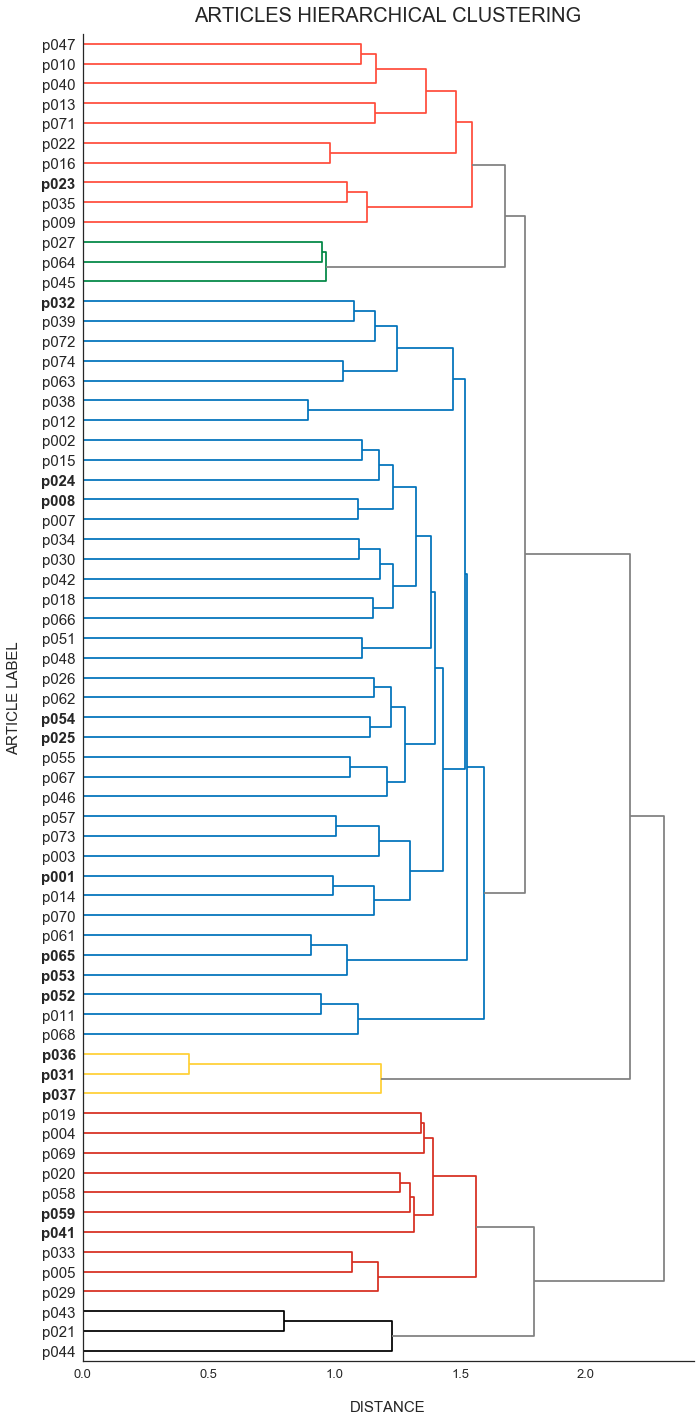

In [133]:
def dendogram(similarity_matrix, article_names):
    
    # Define the linkage_matrix using ward clustering pre-computed distances
    linkage_matrix = ward(similarity_matrix)
    sns.set_style('white')

    # Set figure size
    fig, ax = plt.subplots(figsize=(10, 20)) 
    
    plt.title('ARTICLES HIERARCHICAL CLUSTERING', size =20, y=1.005)

    set_link_color_palette(['#000000','#d62d20', '#FFD034', '#0072BB', '#008744', '#FF4C3B'])
    
    dendrogram(linkage_matrix, orientation="right", labels=article_names, above_threshold_color='grey')
    sns.despine()

    plt.xlabel('DISTANCE', size=15 , labelpad=20)
    plt.ylabel('ARTICLE LABEL', size = 15, labelpad=20)
    
    plt.tick_params(axis= 'y', labelsize = 15)
    
    # Making CB Bold
    [item.set_weight("bold") for item in ax.get_yticklabels() if item.get_text() in cb]


    
    plt.tight_layout()
    
dendogram(similarity_matrix, article_labels)

# Heatmap

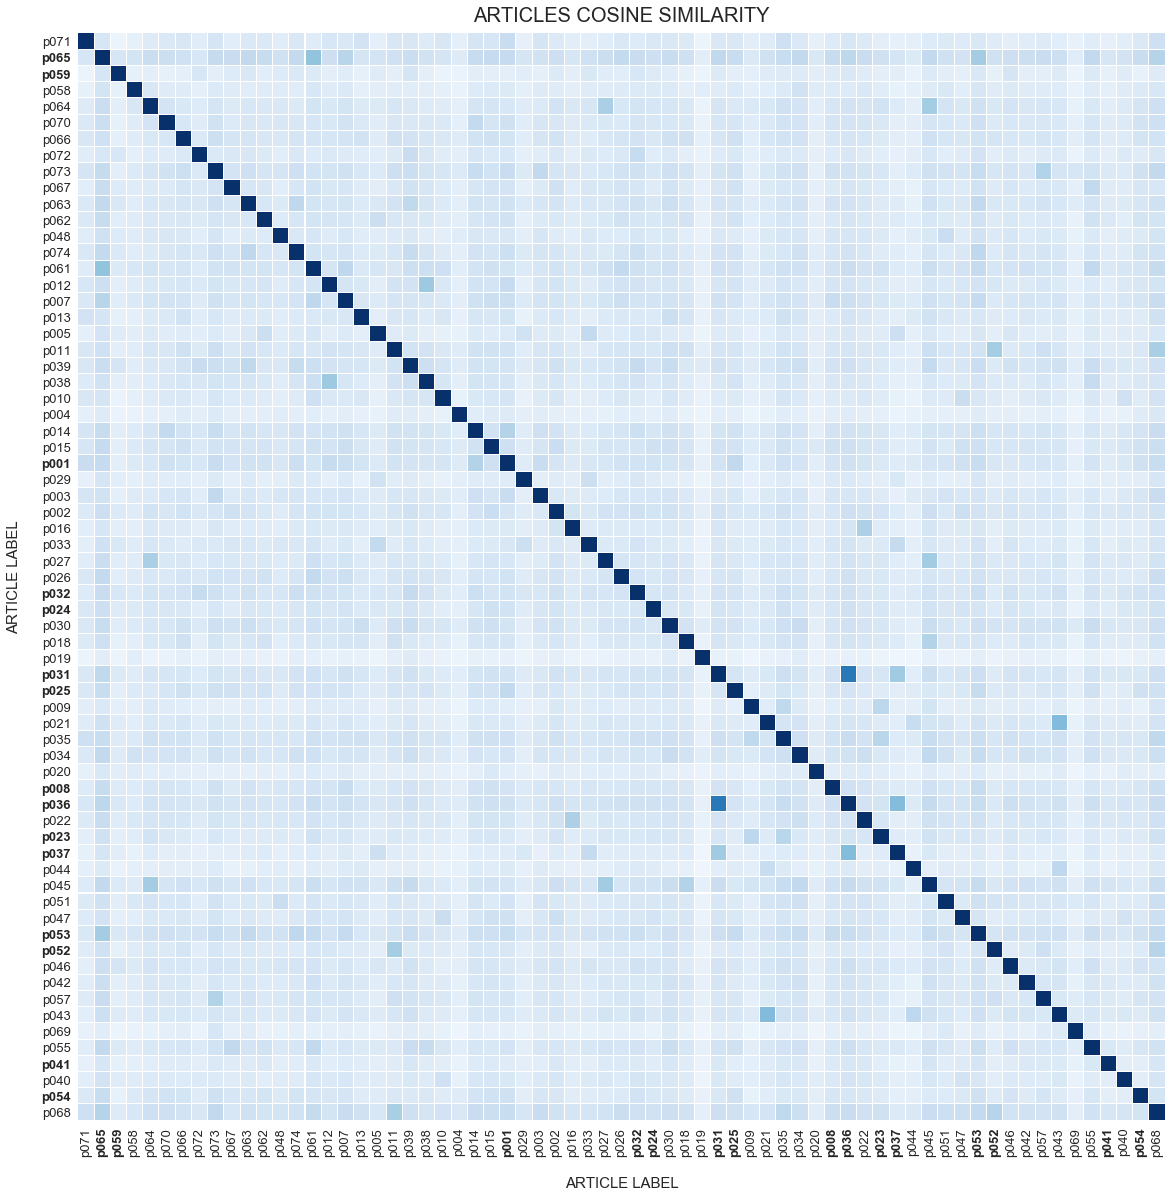

In [25]:

sns.set_style('white')
sns.set(font_scale=1.3)
mask = np.zeros_like(similarity_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap_similarity = pd.DataFrame(similarity_matrix,
                                    columns = article_labels,
                                    index = article_labels)

f, ax = plt.subplots(figsize=(20,20))
plt.title('ARTICLES COSINE SIMILARITY', size =20, y=1.005)


fig = sns.heatmap(heatmap_similarity,
                mask=mask,
                vmax=1,vmin =0,
                cmap="Blues",
                cbar=False,
                square=True, linewidths=0.01,ax=ax)

plt.xlabel('ARTICLE LABEL', size=15 , labelpad=20)
plt.ylabel('ARTICLE LABEL', size = 15, labelpad=20)
[item.set_weight("bold") for item in ax.get_yticklabels() if item.get_text() in cb]
[item.set_weight("bold") for item in ax.get_xticklabels() if item.get_text() in cb]




ax.title
plt.show()




# LSA ANALYSIS AND CLUSTERING

- Explained variance increases linearly with each component adds ~2% of variance explained

In [101]:
# Helper functions
def get_cluster_kmeans(tfidf_matrix, num_clusters):
    """
    Cluster papers into groups using kmeans
    
    Return:
     - class labels
    """
    km = KMeans(n_clusters = num_clusters, n_init=25)
    km.fit(tfidf_matrix)
    cluster_list = km.labels_.tolist()
    
    return cluster_list

def pca_reduction(similarity_matrix, n_components):
    # If we substract 1 - similarity matrix we get proper distance measure
    one_min_sim = 1 - similarity_matrix
    
    pca = PCA(n_components=10)
    pos = pca.fit_transform(one_min_sim)
    x_pos, y_pos = pos[:, 0], pos[:, 4]
    
    return (x_pos, y_pos)

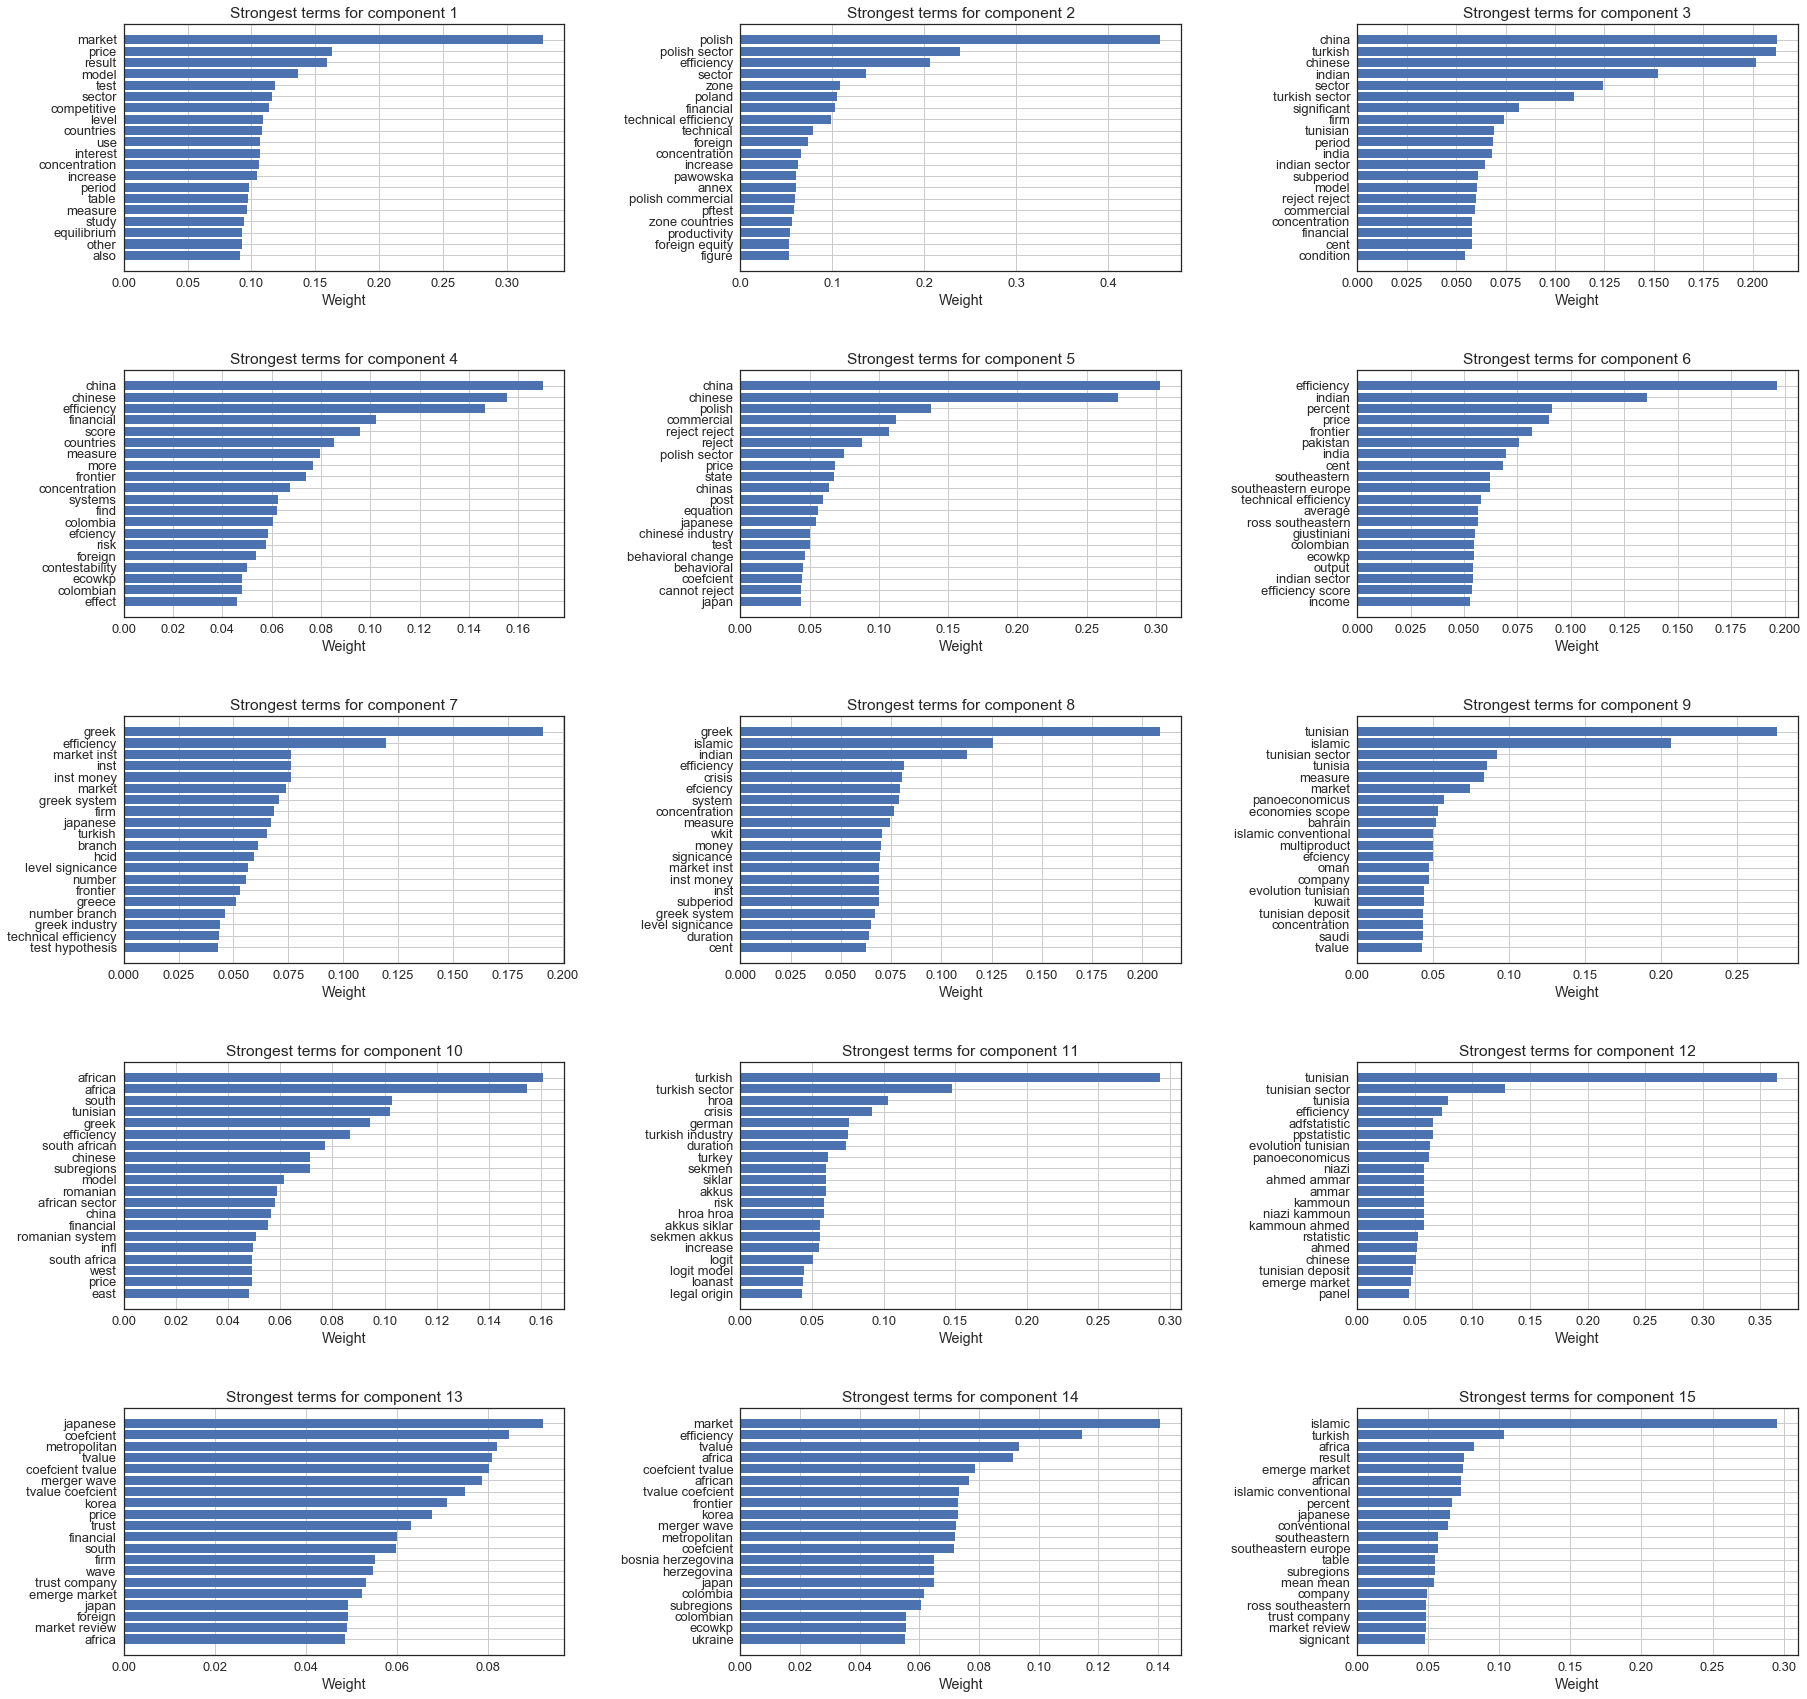

In [102]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa_model = TruncatedSVD(n_components=15)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)


# The SVD matrix will have one row per component, and one column per feature
# of the original data.

fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for compNum in range(0, 15):

    comp = lsa_model.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 20 terms which have the highest weight in this component.        
    terms = [tfidf_terms[weightIndex] for weightIndex in indeces[0:20]]  
    weights = [comp[weightIndex] for weightIndex in indeces[0:20]]    

    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = np.arange(20) + .5  # the bar centers on the y axis
    
    ax = fig.add_subplot(5, 3, compNum + 1)
    ax.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (compNum + 1))
    plt.grid(True)
    
plt.show()

## SVD components value

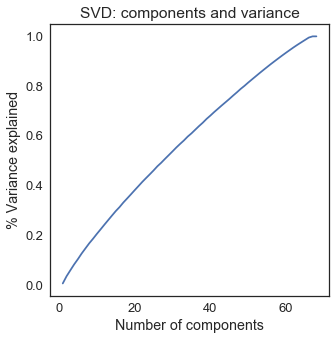

In [222]:
# Linear increase in variance explaines
# explained_variance = []
# for i in range(1, 69):
#     svd = TruncatedSVD(i)
#     lsa = make_pipeline(svd, Normalizer(copy=False))

#     # Run SVD on the training data, then project the training data.
#     lsa_topic_matrix = lsa.fit_transform(tfidf_matrix)

#     explained_variance.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(5,5))
plt.title('SVD: components and variance')
plt.xlabel('Number of components')
plt.ylabel('% Variance explained')
plt.plot(range(1,69), explained_variance)

## Components with highers weight per article

In [229]:
best_component = []
for i in range(0, 67):
    component_weight = np.argsort(lsa_topic_matrix[i]).tolist()
    component_weight.reverse()
    
    # Take second value since first component always shows highest frequency count
    best_component.append(component_weight[1])
    
best_components_df = pd.DataFrame([best_component, article_labels]).T

best_components_df[best_components_df[1].isin(cb)]

,0,1
1,65,p065
2,29,p059
26,60,p001
34,56,p032
35,40,p024
39,6,p031
40,32,p025
46,24,p008
47,66,p036
49,45,p023


# K-means on LSA component matrix

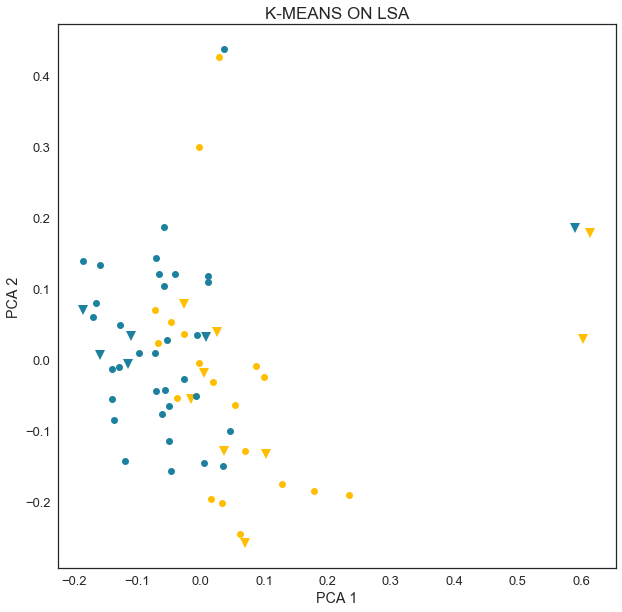

In [31]:
pca_lsa = pca_reduction(lsa_topic_matrix, 2)
km_clusters = get_cluster_kmeans(lsa_topic_matrix, 4)
cb_mask = [ 1 if article in cb else 0 for article in article_labels]

test_df = pd.DataFrame({'x':pca_lsa[0],
                        'y':pca_lsa[1],
                        'cb': cb_mask,
                        'cluster': km_clusters})

sns.set_style('white')

fig, ax = plt.subplots(figsize=(10,10))

plt.title('K-MEANS ON LSA', size=17)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


for x, y, mask, cluster  in zip(test_df.x, test_df.y, test_df.cb, test_df.cluster):
    if cluster == 1:
        color = '#ffbe00'
    if cluster == 0:
        color = '#1c819e'

    if mask == 1:
        ax.plot(x, y, marker='v', linestyle='', ms=10, c=color)
    else:
        ax.plot(x, y, marker='o', linestyle='', ms=7, c=color)

plt.show()

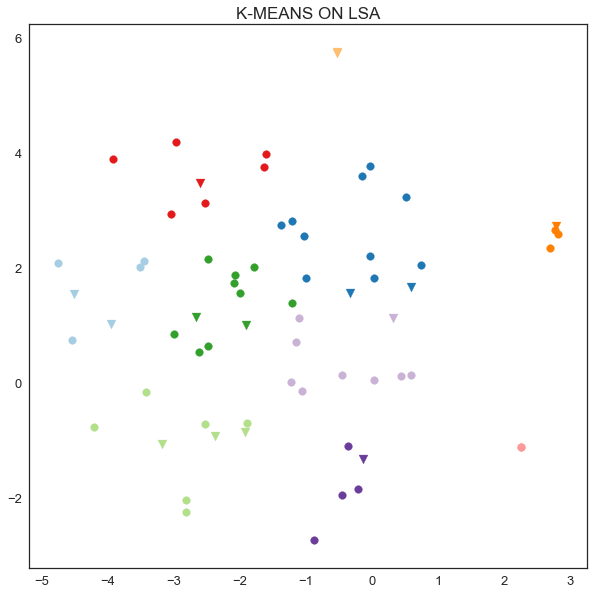

In [149]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate=100)
transformed = model.fit_transform(lsa_topic_matrix)
km_clusters = get_cluster_kmeans(transformed, 10)
cb_mask = [ 1 if article in cb else 0 for article in article_labels]
xs = transformed[:,0]
ys = transformed[:,1]

fig, ax = plt.subplots(figsize=(10,10))
plt.title('K-MEANS ON LSA', size=17)

for mask, x, y, cluster, txt in zip(cb_mask, xs, ys, km_clusters, article_labels):


    color = sns.color_palette("Paired", 10)[cluster] 
    
    
    if mask == 1:
            ax.scatter(x, y, marker='v', c=color, s=80)
            #ax.annotate(txt, (x, y))

    else:
            ax.scatter(x, y, marker='o', c=color, s=60)
            #ax.annotate(txt, (x, y))


plt.show()

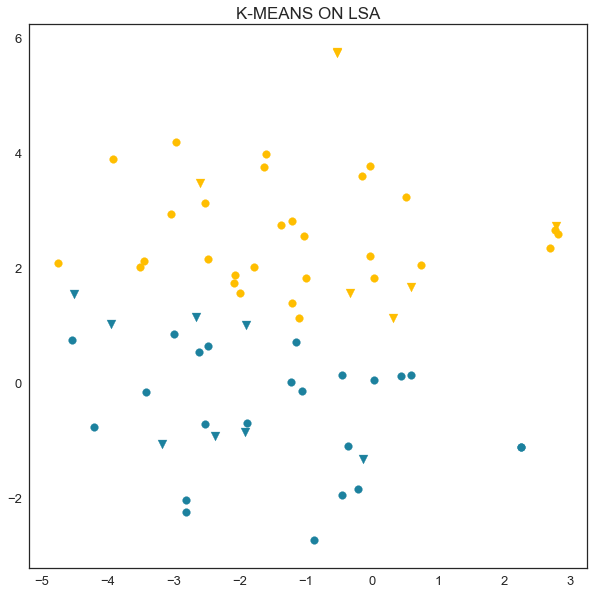

In [150]:
km_clusters = get_cluster_kmeans(transformed, 2)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('K-MEANS ON LSA', size=17)

for mask, x, y, cluster, txt in zip(cb_mask, xs, ys, km_clusters, article_labels):


    color = sns.color_palette("deep", 10)[cluster] 
    
    if cluster == 1:
        color = '#ffbe00'
    if cluster == 0:
        color = '#1c819e'
    
    if mask == 1:
            ax.scatter(x, y, marker='v', c=color, s=80)
            #ax.annotate(txt, (x, y))

    else:
            ax.scatter(x, y, marker='o', c=color, s=60)
            #ax.annotate(txt, (x, y))


plt.show()

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

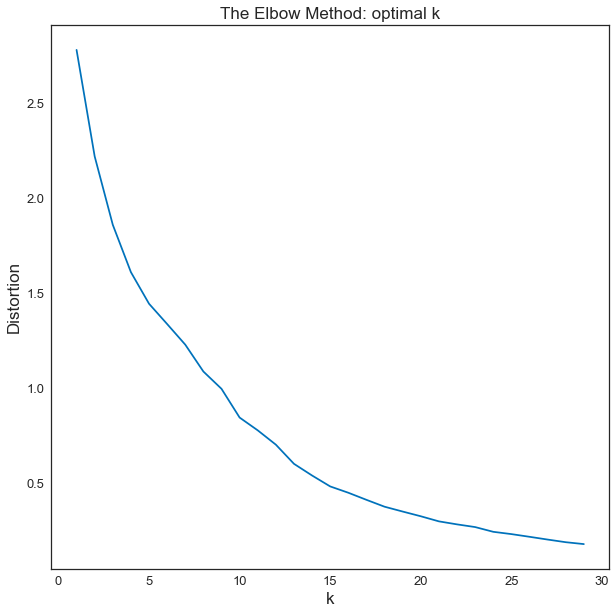

In [97]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(transformed)
    # Euclidean distance between the each data with the cluster center distance
    distortions.append(sum(np.min(cdist(transformed, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / transformed.shape[0])

# Plot the elbow
plt.subplots(figsize=(10,10))
plt.plot(K, distortions, c ='#0072BB' )
plt.xlabel('k', size = 17)
plt.ylabel('Distortion', size = 17)
plt.title('The Elbow Method: optimal k', size=17)
plt.show()

# LDA Topic modelling
- Since we are looking at papers with single topic the analysis confirms that some terms appear in most of the papers and creates
single big topic that covers 98.2% of the tokens

In [98]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

pyLDAvis.enable_notebook()

tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2))

tfidf_mat = tfidf_vectorizer.fit_transform(texts_str_clean)

lda = LatentDirichletAllocation(n_components=10, learning_method='online')

lda_matrix = lda.fit(tfidf_matrix)

pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_mat, tfidf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      98.235782        1       1  0.000675  0.000002
1       0.882302        1       2 -0.000332 -0.000225
0       0.881916        1       3 -0.000342  0.000223, topic_info=       Category      Freq                        Term     Total  loglift  \
term                                                                       
118057  Default  0.000000                      sector  0.000000  30.0000   
113090  Default  0.000000                      result  0.000000  29.0000   
22458   Default  0.000000                 competition  0.000000  28.0000   
140008  Default  0.000000                         use  0.000000  27.0000   
101902  Default  0.000000                       price  0.000000  26.0000   
132174  Default  0.000000                       table  0.000000  25.0000   
44281   Default  0.000000                 equilibrium  0.000000  24.0000   
28576   Default  0.000000                        cost  0.000000  23.0000   
22998   Default  0.000000                 competitive  0.000000  22.0000   
133739  Default  0.000000                        test  0.000000  21.0000   
97301   Default  0.000000                      period  0.000000  20.0000   
84351   Default  0.000000                       model  0.000000  19.0000   
141285  Default  0.000000                    variable  0.000000  18.0000   
141699  Default  0.000000                   variables  0.000000  17.0000   
29388   Default  0.000000                   countries  0.000000  16.0000   
85977   Default  0.000000                        more  0.000000  15.0000   
51186   Default  0.000000                   financial  0.000000  14.0000   
74467   Default  0.000000                       level  0.000000  13.0000   
45481   Default  0.000000                    estimate  0.000000  12.0000   
107231  Default  0.000000                       ratio  0.000000  11.0000   
31985   Default  0.000000                        data  0.000000  10.0000   
80289   Default  0.000000                      market  0.000000   9.0000   
23931   Default  0.000000               concentration  0.000000   8.0000   
64368   Default  0.000000                    increase  0.000000   7.0000   
33634   Default  0.000000                      degree  0.000000   6.0000   
68925   Default  0.000000                    interest  0.000000   5.0000   
67656   Default  0.000000                 input price  0.000000   4.0000   
129017  Default  0.000000                       study  0.000000   3.0000   
13648   Default  0.000000                     between  0.000000   2.0000   
4163    Default  0.000000                        also  0.000000   1.0000   
...         ...       ...                         ...       ...      ...   
100843   Topic3  0.000203                  powerhouse  0.019357   0.1725   
77139    Topic3  0.000203           loan associations  0.019823   0.1509   
118148   Topic3  0.000203           sector commercial  0.019756   0.1532   
108987   Topic3  0.000203                 reform conc  0.019942   0.1444   
18219    Topic3  0.000204                     ceteris  0.020430   0.1230   
68565    Topic3  0.000203                insufficient  0.020132   0.1351   
69       Topic3  0.000204             ability capture  0.021540   0.0734   
22549    Topic3  0.000204  competition contestability  0.021068   0.0933   
22998    Topic3  0.000235                 competitive  0.104392  -1.3642   
101902   Topic3  0.000240                       price  0.143168  -1.6611   
65353    Topic3  0.000216                      indian  0.041328  -0.5213   
80289    Topic3  0.000247                      market  0.277028  -2.2935   
140008   Topic3  0.000227                         use  0.101935  -1.3770   
133739   Topic3  0.000228                        test  0.110929  -1.4576   
22458    Topic3  0.000223                 competition  0.092360  -1.2938   
113090   Topic3  0.000226              

In [97]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
no_top_words = 10
display_topics(lda, tfidf_terms, no_top_words)

Topic 0:
market bank price result model cost test sector competitive level
Topic 1:
systems likely frontier intercept firm belong investors exception ypln about productivity slump upward market consequently denicolo spread however
Topic 2:
mike stiele value most market imply weak method formal pretransition period competition differ study even stability nurture moreover disagreement
Topic 3:
bank management however most sector staikouras misspe service ibca contestability proxy study regard equilib rium erste modernisation capital
Topic 4:
priceelastic contestable comp countries complete dataset koutsomanolifillipaki another market edward hypotheses indicate kleniobarbosafgvbr barbosa sample micropanel power variable similar rest
Topic 5:
table variable magnitude elasticity important topic risk effect components weight authorities utilize constitute sink publics involve autocorrelated stage market
Topic 6:
yitsit xitsit price ratio relation result deterioration performance market role 

# Corpus with removed country names

In [120]:
import clean_txt as clean

context_stopwords = ['panzar', 'rosse','panzarrosse', 'rossepanzar', 'prh','journal', 'sciencedirect',
                     'banking', 'rosse–panzar', 'vol', 'department', 'university', 'school', 'economics',
                     'business', 'email', 'cid', 'blackwell', 'jointstock' ,'bank', 'banking', 'asset', 'assets', 'revenue', 'total', 
                     'hstatistic', 'h-statistic', 'hindex', 'lerner', 'boone', 'competition', 'finance', 'banks','spierdijk', 'bikker'
                     'httpaboutjstororgterms', 'lniiit', 'lnii', 'httpaboutjstororgterms', 'lniiita', 'eects', 'oiiiiit', 'oiiiit',
                     'oiii', 'euro', 'euro zone', 'quar', 'lniita', 'issn', 'wwwhrmarscom', 'apergis', 'compilation', 'nancial',
                     'download', 'content', 'fosu', 'hstat', 'index', 'academic', 'research', 'journal', 'banco', 'jstor', 'logta',
                     'costsdeposits', 'cost', 'ebrd', 'country', 'stateowned', 'science', 'social', 'publish', 'classic', 'konstantinou',
                     'greek', 'turkey', 'turkish', 'europe', 'european', 'czech', 'africa', 'african', 'germany', 'german',
                     'poland', 'polish', 'china', 'chinese', 'india', 'indian', 'tunisia', 'tunisian', 'japan', 'japanese',
                     'islamic', 'zimbabwean', 'columbia', 'columbian', 'pakistan', 'oman', 'korea', 'korean', 'ukraine',
                     'south', 'bosnia', 'herzegovina', 'argentina', 'jamaica', 'jamaican', 'italy', 'italian', 'jordanian',
                     'malyasia', 'malyasian', 'asia', 'british', 'britan', 'uk', 'kuwait', 'bahrain']

# List of tokenized documents
texts_token_clean = [[word for word in document if word not in context_stopwords] for document in texts_token_clean]

# List of clean strings
texts_str_clean = convert_list(texts_token_clean)

# Similatities and tfidf
similarity_matrix, distance_matrix, tfidf_matrix, tfidf_terms  = get_similarity_matrix(texts_str_clean)

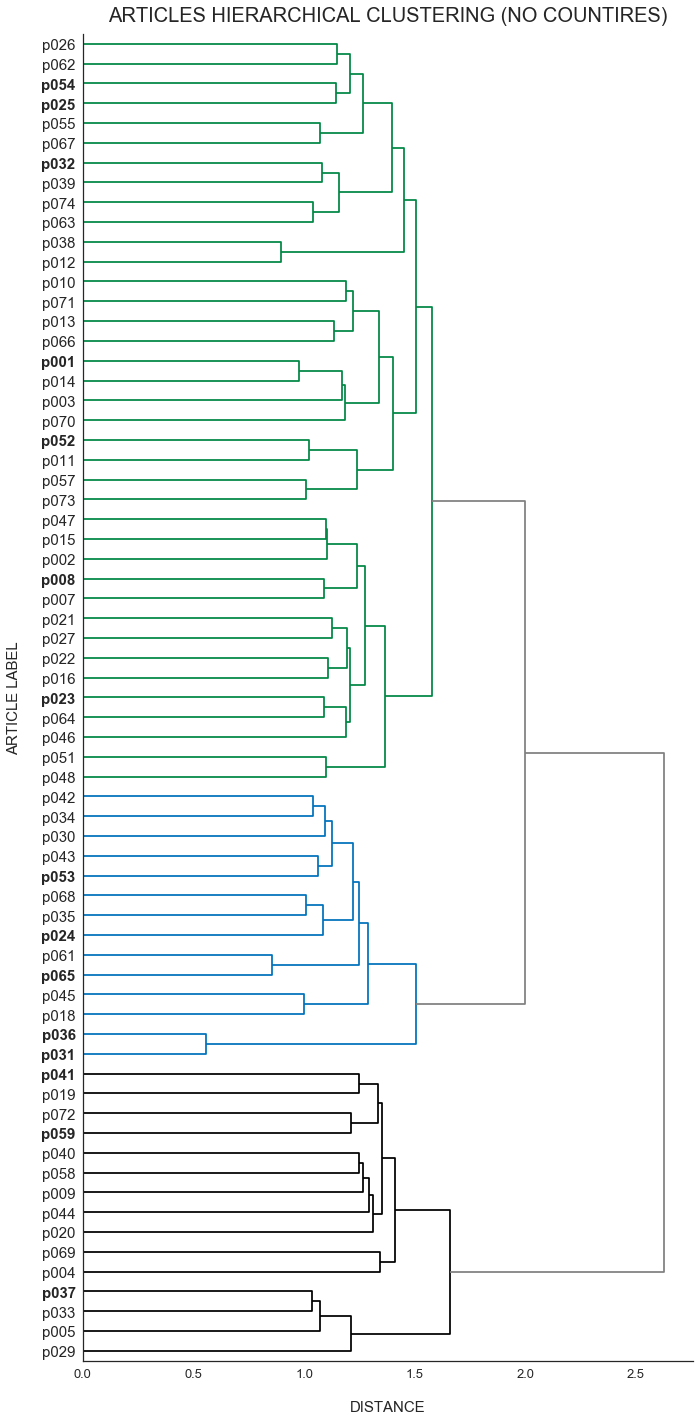

In [224]:
def dendogram(similarity_matrix, article_names):
    
    # Define the linkage_matrix using ward clustering pre-computed distances
    linkage_matrix = ward(similarity_matrix)
    sns.set_style('white')

    # Set figure size
    fig, ax = plt.subplots(figsize=(10, 20)) 
    
    plt.title('ARTICLES HIERARCHICAL CLUSTERING (NO COUNTIRES)', size =20, y=1.005)

    set_link_color_palette(['#000000','#0072BB', '#008744', '#008744', '#FF4C3B'])
    
    dendrogram(linkage_matrix, orientation="right", labels=article_names, above_threshold_color='grey')
    sns.despine()

    # Making CB Bold
    [item.set_weight("bold") for item in ax.get_yticklabels() if item.get_text() in cb]


    
    plt.xlabel('DISTANCE', size=15 , labelpad=20)
    plt.ylabel('ARTICLE LABEL', size = 15, labelpad=20)
    
    plt.tick_params(axis= 'y', labelsize = 15)
    
    plt.tight_layout()
    
dendogram(similarity_matrix, article_labels)

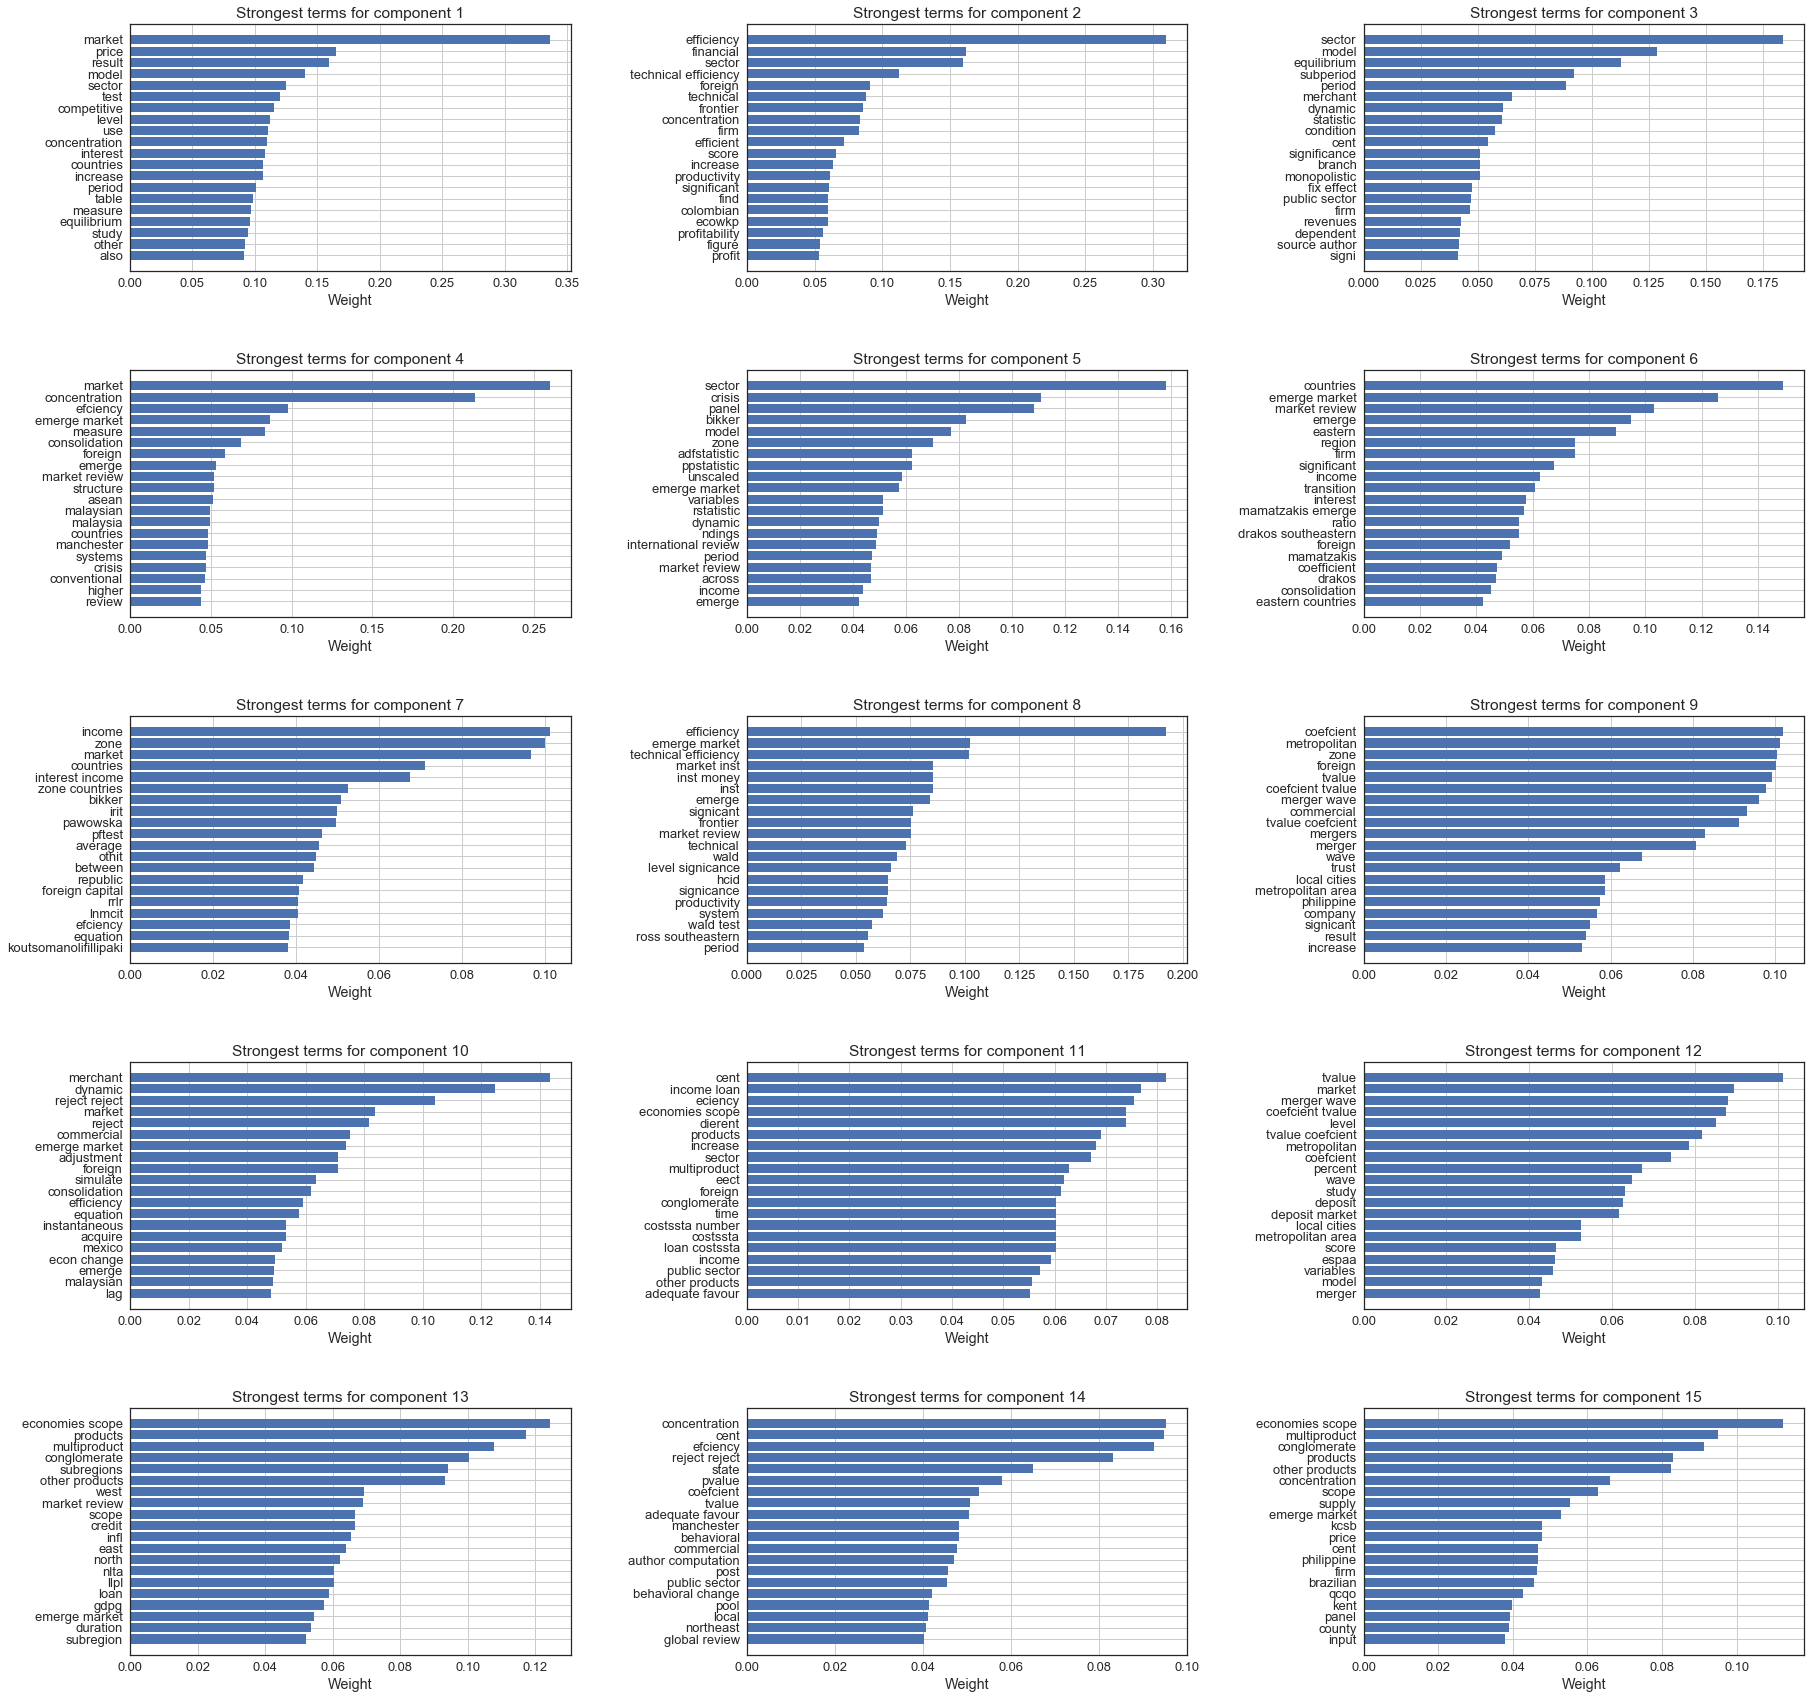

In [121]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa_model = TruncatedSVD(n_components=15)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)


# The SVD matrix will have one row per component, and one column per feature
# of the original data.

fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for compNum in range(0, 15):

    comp = lsa_model.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 20 terms which have the highest weight in this component.        
    terms = [tfidf_terms[weightIndex] for weightIndex in indeces[0:20]]  
    weights = [comp[weightIndex] for weightIndex in indeces[0:20]]    

    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = np.arange(20) + .5  # the bar centers on the y axis
    
    ax = fig.add_subplot(5, 3, compNum + 1)
    ax.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (compNum + 1))
    plt.grid(True)
    
plt.show()

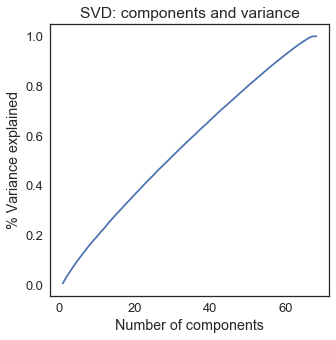

In [226]:
# Linear increase in variance explaines
explained_variance = []
for i in range(1, 69):
    svd = TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))

    # Run SVD on the training data, then project the training data.
    lsa_topic_matrix = lsa.fit_transform(tfidf_matrix)

    explained_variance.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(5,5))
plt.title('SVD: components and variance')
plt.xlabel('Number of components')
plt.ylabel('% Variance explained')
plt.plot(range(1,69), explained_variance)

In [53]:
best_component = []
for i in range(0, 67):
    component_weight = np.argsort(lsa_topic_matrix[i]).tolist()
    component_weight.reverse()
    
    # Take second value since first component always shows highest frequency count
    best_component.append(component_weight[1])
    
best_components_df = pd.DataFrame([best_component, article_labels]).T

best_components_df[best_components_df[1].isin(cb)]
best_components_df[best_components_df[0].isin([12,14,15])]

,0,1
6,14,p066
9,14,p067
11,14,p062
25,14,p015
36,14,p030
37,14,p018
38,14,p019
45,12,p020
63,14,p041


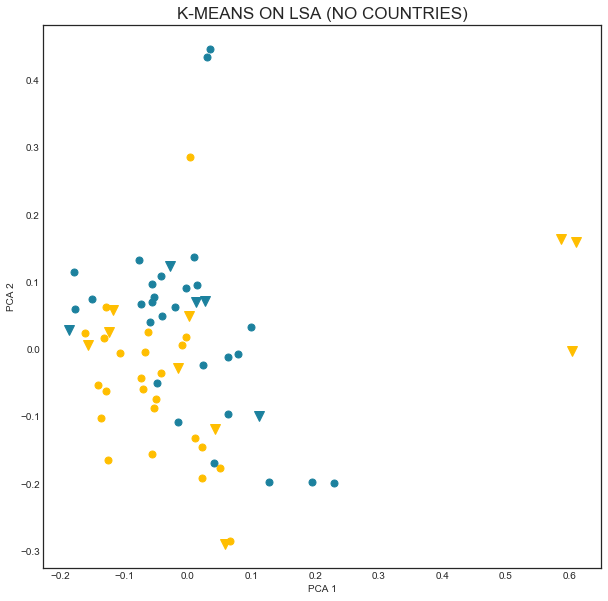

In [37]:
pca_lsa = pca_reduction(lsa_topic_matrix, 2)
km_clusters = get_cluster_kmeans(lsa_topic_matrix, 4)
cb_mask = [ 1 if article in cb else 0 for article in article_labels]

test_df = pd.DataFrame({'x':pca_lsa[0],
                        'y':pca_lsa[1],
                        'cb': cb_mask,
                        'cluster': km_clusters})

sns.set_style('white')

fig, ax = plt.subplots(figsize=(10,10))

plt.title('K-MEANS ON LSA (NO COUNTRIES)', size=17)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


for x, y, mask, cluster  in zip(test_df.x, test_df.y, test_df.cb, test_df.cluster):
    if cluster == 1:
        color = '#ffbe00'
    if cluster == 0:
        color = '#1c819e'

    if mask == 1:
        ax.plot(x, y, marker='v', linestyle='', ms=10, c=color)
    else:
        ax.plot(x, y, marker='o', linestyle='', ms=7, c=color)

plt.show()

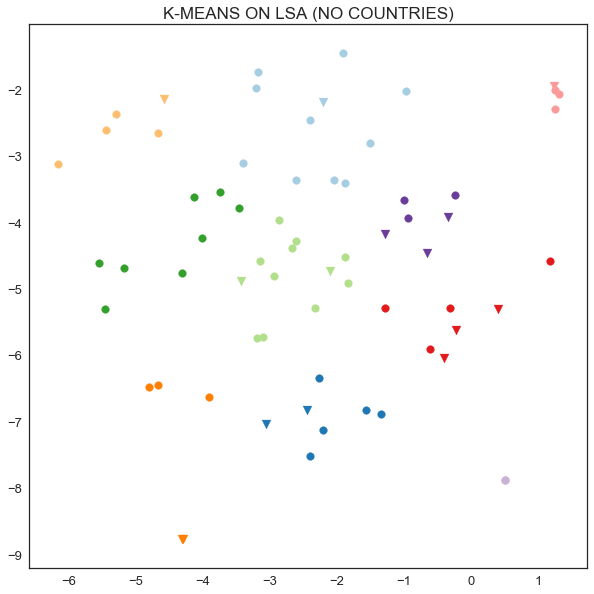

In [144]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate=100)
transformed = model.fit_transform(lsa_topic_matrix)
km_clusters = get_cluster_kmeans(transformed, 10)
cb_mask = [ 1 if article in cb else 0 for article in article_labels]
xs = transformed[:,0]
ys = transformed[:,1]

fig, ax = plt.subplots(figsize=(10,10))
plt.title('K-MEANS ON LSA (NO COUNTRIES)', size=17)

for mask, x, y, cluster, txt in zip(cb_mask, xs, ys, km_clusters, article_labels):


    color = sns.color_palette("Paired", 10)[cluster]    
    
    if mask == 1:
            ax.scatter(x, y, marker='v', c=color, s=80)
            #ax.annotate(txt, (x, y))

    else:
            ax.scatter(x, y, marker='o', c=color, s=60)
            #ax.annotate(txt, (x, y))


plt.show()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745)]

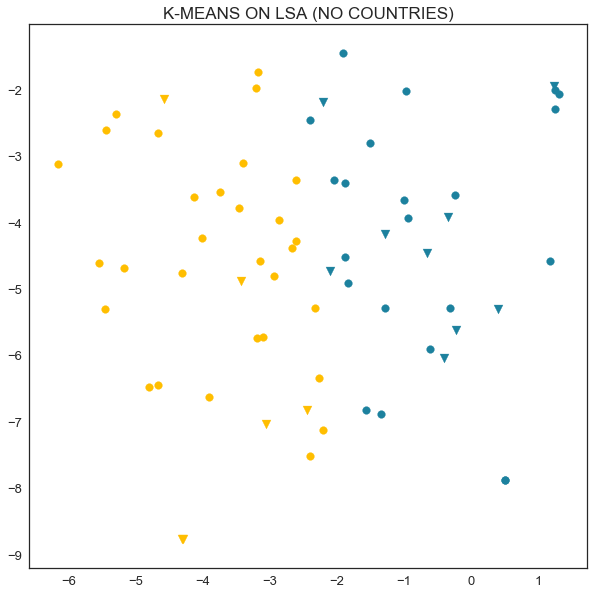

In [145]:
km_clusters = get_cluster_kmeans(transformed, 2)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('K-MEANS ON LSA (NO COUNTRIES)', size=17)

for mask, x, y, cluster, txt in zip(cb_mask, xs, ys, km_clusters, article_labels):


    color = sns.color_palette("deep", 10)[cluster] 
    
    if cluster == 1:
        color = '#ffbe00'
    if cluster == 0:
        color = '#1c819e'
    
    if mask == 1:
            ax.scatter(x, y, marker='v', c=color, s=80)
            #ax.annotate(txt, (x, y))

    else:
            ax.scatter(x, y, marker='o', c=color, s=60)
            #ax.annotate(txt, (x, y))


plt.show()

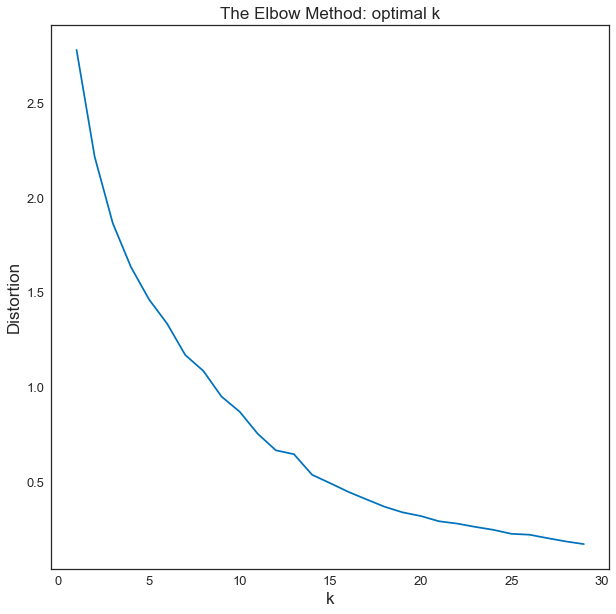

In [82]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(transformed)
    # Euclidean distance between the each data with the cluster center distance
    distortions.append(sum(np.min(cdist(transformed, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / transformed.shape[0])

# Plot the elbow
plt.subplots(figsize=(10,10))
plt.plot(K, distortions, c ='#0072BB')
plt.xlabel('k', size = 17)
plt.ylabel('Distortion', size = 17)
plt.title('The Elbow Method: optimal k', size=17)
plt.show()